In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 14
num_exps = 20
num_repeats_per_exp = 1

# policies = [
#     'ens jensen greedy_500',
#     'classical ens_500',
#     'greedy',
#     'round robin greedy',
# ]
# names = [
#     'ens jensen greedy',
#     'classical ens',
#     'greedy',
#     'round robin greedy',
# ]
policies = [
    'round robin ucb_0.1',
    'round robin ucb_0.3',
    'round robin ucb_1.0',
    'round robin ucb_3.0',
    'round robin ucb_10.0',
]
names = policies
assert len(policies) == len(names)
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)
basepath = os.path.join('../../data/results/results_ucb_main', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            try:
                labels = np.loadtxt(
                    os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                    dtype=int
                ).flatten() - 1

                utilities[p_ind, exp_ind, i, :] = utility_function(labels_to_counts(labels))
            except OSError:
                print(policy, exp_ind + 1, i + 1)
        
# assert np.all(utilities != -1)

In [3]:
utilities.shape

(5, 20, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([24.90625518, 24.86929747, 23.99444758, 25.9785752 , 26.44810294])

ens jensen greedy_500: 23.39
classical ens_500: 13.79
greedy: 19.06
round robin greedy: 18.66


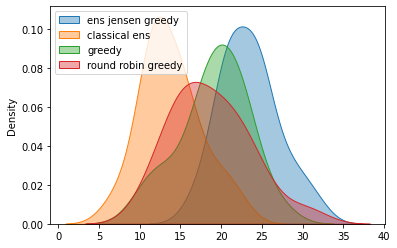

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.2f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=names[p_ind])
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(4, 20, 1, 501)


array([[[[ 0.69314718,  0.69314718,  0.69314718, ..., 23.59131932,
          23.66031219, 23.72485071]],

        [[ 0.69314718,  1.09861229,  1.09861229, ..., 21.27276729,
          21.28876763, 21.30451599]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 18.82406369,
          18.84604259, 18.8680215 ]],

        ...,

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 21.1276426 ,
          21.1276426 , 21.1276426 ]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 20.58764733,
          20.58764733, 20.58764733]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 26.40595394,
          26.43874376, 26.43874376]]],


       [[[ 0.69314718,  1.38629436,  1.79175947, ..., 12.17739535,
          12.17739535, 12.17739535]],

        [[ 0.69314718,  1.09861229,  1.38629436, ...,  6.90374726,
           6.90575328,  6.90775528]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 18.84389461,
          18.84389461, 18.84389461]],

        ...,

        [[ 0.693

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(4, 20, 501)


array([[[ 0.69314718,  0.69314718,  0.69314718, ..., 23.59131932,
         23.66031219, 23.72485071],
        [ 0.69314718,  1.09861229,  1.09861229, ..., 21.27276729,
         21.28876763, 21.30451599],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 18.82406369,
         18.84604259, 18.8680215 ],
        ...,
        [ 0.69314718,  0.69314718,  1.09861229, ..., 21.1276426 ,
         21.1276426 , 21.1276426 ],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 20.58764733,
         20.58764733, 20.58764733],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 26.40595394,
         26.43874376, 26.43874376]],

       [[ 0.69314718,  1.38629436,  1.79175947, ..., 12.17739535,
         12.17739535, 12.17739535],
        [ 0.69314718,  1.09861229,  1.38629436, ...,  6.90374726,
          6.90575328,  6.90775528],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 18.84389461,
         18.84389461, 18.84389461],
        ...,
        [ 0.69314718,  1.09861229,  1.38629436, ..., 1

In [8]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy_500 vs. classical ens_500
2.212711518081943e-08
ens jensen greedy_500 vs. greedy
0.0006228315249484382
ens jensen greedy_500 vs. round robin greedy
5.277620275348468e-05

classical ens_500 vs. greedy
3.716863785677718e-05
classical ens_500 vs. round robin greedy
0.0010349418259852977

greedy vs. round robin greedy
0.37078527313107035



21.728115956136065 25.057441307148338
0.83
12.081780603902718 15.501355213821352
0.85
17.11255294361891 21.014933224800806
0.98
16.40771882386454 20.91033123833837
1.13


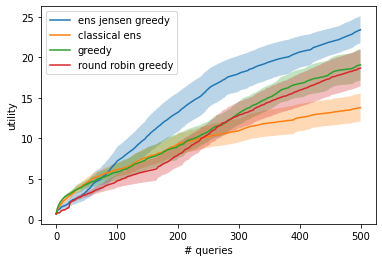

In [9]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=names[p_ind])
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.2f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();